Makespan: 11.14 seconds
MinMakespan: 0.86 seconds
Min EXT: 0.00 seconds
Total Cost: 1066.92 $
Total Energy: 0.00 kWh
Unassigned Tasks: 0


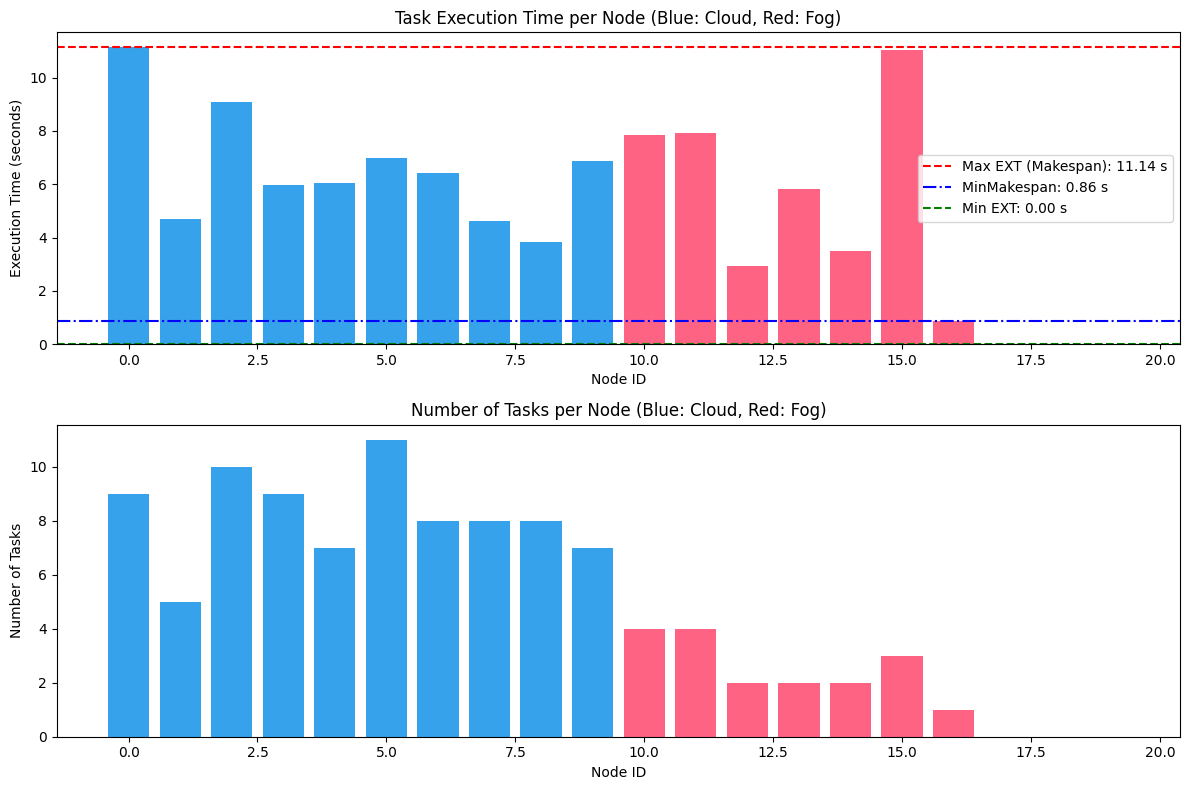

In [8]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Set a seed for reproducibility
random.seed(42)

# Define the Node class
class Node:
    """
    Represents a node in the cloud-fog computing environment.

    Attributes:
        id (int): Unique identifier for the node.
        is_cloud (bool): True if the node is a cloud node, False if it's a fog node.
        cpu_rate (float): Processing capacity in MIPS (Millions of Instructions Per Second).
        available_cpu (float): Current available CPU capacity in MIPS.
        available_ram (float): Current available RAM in MB.
        available_storage (float): Current available storage in MB.
        bandwidth (float): Network bandwidth in Mbps.
        cpu_cost (float): Cost of CPU usage in $ per second.
        memory_cost (float): Cost of memory usage in $ per MB.
        bandwidth_cost (float): Cost of bandwidth usage in $ per MB.
        energy_cost (float): Cost of energy usage in $ per kWh.
        latency (float): Network latency in ms.
        power_consumption (float): Power consumption in watts.
        location (tuple): Geographical location as (x, y) coordinates.
        tasks (list): List of tasks assigned to this node.
        ext (float): Total execution time for all tasks assigned to this node.
        total_cost (float): Total cost incurred by this node.
        total_energy (float): Total energy consumed by this node in kWh.
    """
    def __init__(self, id, is_cloud=True):
        self.id = id
        self.is_cloud = is_cloud

        # Computational resources
        self.cpu_rate = random.uniform(5000, 10000) if is_cloud else random.uniform(2000, 5000)  # MIPS
        self.available_cpu = self.cpu_rate  # Initial available CPU
        self.available_ram = random.uniform(4000, 8000) if is_cloud else random.uniform(2000, 4000)  # MB
        self.available_storage = random.uniform(20000, 50000) if is_cloud else random.uniform(5000, 20000)  # MB
        self.bandwidth = random.uniform(500, 1000) if is_cloud else random.uniform(100, 500)  # Mbps

        # Costs
        self.cpu_cost = random.uniform(0.2, 0.5) if is_cloud else random.uniform(0.1, 0.3)  # $/s
        self.memory_cost = random.uniform(0.02, 0.05) if is_cloud else random.uniform(0.01, 0.03)  # $/MB
        self.bandwidth_cost = random.uniform(0.01, 0.03)  # $/MB
        self.energy_cost = random.uniform(0.05, 0.1)  # $/kWh

        # Network latency
        self.latency = random.uniform(10, 50) if is_cloud else random.uniform(1, 10)  # ms

        # Power consumption
        self.power_consumption = random.uniform(100, 500) if is_cloud else random.uniform(50, 200)  # watts

        # Location
        self.location = (random.uniform(0, 100), random.uniform(0, 100))  # (x, y)

        # Assigned tasks
        self.tasks = []

        # Total execution time
        self.ext = 0

        # Total cost
        self.total_cost = 0

        # Total energy
        self.total_energy = 0

    def can_handle_task(self, task):
        """
        Check if the node has sufficient resources to handle the task.

        Args:
            task (Task): The task to be checked.

        Returns:
            bool: True if the node can handle the task, False otherwise.
        """
        return (self.available_cpu >= task.cpu and
                self.available_ram >= task.ram and
                self.available_storage >= task.storage)

    def assign_task(self, task):
        """
        Assign the task to this node and update resources, costs, and energy.

        Args:
            task (Task): The task to be assigned.
        """
        self.tasks.append(task)

        # Calculate processing time: total instructions / processing rate
        processing_time = task.cpu / self.cpu_rate  # seconds

        # Calculate transfer time including latency
        # Latency is in ms, so convert to seconds
        transfer_time = (self.latency / 1000) + (task.data_size * 8) / self.bandwidth  # seconds

        # Total time for this task on this node
        task_time = processing_time + transfer_time

        # Add to total execution time
        self.ext += task_time

        # Update available resources
        self.available_cpu -= task.cpu
        self.available_ram -= task.ram
        self.available_storage -= task.storage

        # Calculate costs
        # CPU cost: processing_time * cpu_cost ($/s)
        # Memory cost: task.ram * memory_cost ($/MB) (simplified as total cost for assignment)
        # Bandwidth cost: task.data_size * bandwidth_cost ($/MB)
        self.total_cost += (processing_time * self.cpu_cost +
                            task.ram * self.memory_cost +
                            task.data_size * self.bandwidth_cost)

        # Calculate energy: processing_time in seconds, convert to hours: processing_time / 3600
        # Power in watts, so energy = power * time_in_hours (Wh), then /1000 to kWh
        self.total_energy += (processing_time / 3600) * self.power_consumption / 1000

# Define the Task class
class Task:
    """
    Represents a task to be executed in the cloud-fog environment.

    Attributes:
        id (int): Unique identifier for the task.
        cpu (float): Required CPU instructions in millions.
        ram (float): Required RAM in MB.
        storage (float): Required storage in MB.
        data_size (float): Size of data to be transferred in MB.
        location (tuple): Geographical location where the task is generated.
    """
    def __init__(self, id):
        self.id = id
        self.cpu = random.uniform(500, 1500)  # millions of instructions
        self.ram = random.uniform(100, 500)   # MB
        self.storage = random.uniform(200, 1000)  # MB
        self.data_size = random.uniform(10, 100)  # MB
        self.location = (random.uniform(0, 100), random.uniform(0, 100))  # (x, y)

# Create nodes: 10 cloud and 10 fog
num_nodes = 20
nodes = [Node(i, is_cloud=True) for i in range(10)] + [Node(i+10, is_cloud=False) for i in range(10)]

# Create tasks
num_tasks = 100
tasks = [Task(i) for i in range(num_tasks)]

# Assign tasks using FCFS: for each task in order, assign to the first node (by ID) that can handle it
unassigned_tasks = []
for task in tasks:
    assigned = False
    for node in nodes:  # Nodes are in order of ID: 0 to 19
        if node.can_handle_task(task):
            node.assign_task(task)
            assigned = True
            break
    if not assigned:
        unassigned_tasks.append(task.id)

# Calculate Makespan: maximum ext over all nodes
makespan = max(node.ext for node in nodes)

# Calculate MinMakespan: total task CPU requirements / total CPU rate
total_task_cpu = sum(task.cpu for task in tasks)  # total millions of instructions
total_cpu_rate = sum(node.cpu_rate for node in nodes)  # total MIPS
min_makespan = total_task_cpu / total_cpu_rate  # seconds

# Calculate Min EXT: minimum ext over all nodes
min_ext = min(node.ext for node in nodes)

# Total cost and total energy
total_cost = sum(node.total_cost for node in nodes)
total_energy = sum(node.total_energy for node in nodes)

# Print results
print(f"Makespan: {makespan:.2f} seconds")
print(f"MinMakespan: {min_makespan:.2f} seconds")
print(f"Min EXT: {min_ext:.2f} seconds")
print(f"Total Cost: {total_cost:.2f} $")
print(f"Total Energy: {total_energy:.2f} kWh")
print(f"Unassigned Tasks: {len(unassigned_tasks)}")

# Plot results
plt.figure(figsize=(12, 8))

# Execution time per node
plt.subplot(2, 1, 1)
plt.bar([node.id for node in nodes], [node.ext for node in nodes],
        color=['#36A2EB' if node.is_cloud else '#FF6384' for node in nodes])
plt.axhline(y=makespan, color='r', linestyle='--', label=f'Max EXT (Makespan): {makespan:.2f} s')
plt.axhline(y=min_makespan, color='b', linestyle='-.', label=f'MinMakespan: {min_makespan:.2f} s')
plt.axhline(y=min_ext, color='g', linestyle='--', label=f'Min EXT: {min_ext:.2f} s')
plt.xlabel('Node ID')
plt.ylabel('Execution Time (seconds)')
plt.title('Task Execution Time per Node (Blue: Cloud, Red: Fog)')
plt.legend()

# Number of tasks per node
plt.subplot(2, 1, 2)
plt.bar([node.id for node in nodes], [len(node.tasks) for node in nodes],
        color=['#36A2EB' if node.is_cloud else '#FF6384' for node in nodes])
plt.xlabel('Node ID')
plt.ylabel('Number of Tasks')
plt.title('Number of Tasks per Node (Blue: Cloud, Red: Fog)')

plt.tight_layout()
plt.savefig('cloud_fog_simulation_fcfs_with_latency.png')
plt.show()